In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation as animation
import seaborn as sns
import ipywidgets as widgets

import scipy 
from scipy.signal import savgol_filter
import h5py

In [2]:
import random
random.seed(22)

In [3]:
import sys
sys.path.append("../code/")
from extract_angles import get_tan_angles, get_bend_angles, savgol_skeleton
from extract_curvatures import get_curv_savgol,curvature_grad

# Angles vs curvatures as descriptors of shape of ciona larvae

In [ ]:
dest_file_folder = "/share/data/temp/athira/tierpsy_skeleton_files_for_eigen_npy/"
#dest_file_folder = "/media/athira/Seagate Expansion Drive/Backup_Feb26_2020/athira_data/tierpsy_skeleton_files_for_eigen_npy/"

In [ ]:
# From the saved skeleton arrays, pick the ones belonging to wild or control group 

skel_files_control = [os.path.join(root,name) for root,dirs,filenames in os.walk(dest_file_folder) 
                                              for name in filenames if ((name.endswith('.npy')) & 
                                                                        (name.split("_")[5] == "None") & 
                                                                        (name.split("_")[7] == "None")
                                                                       )]
#print([os.path.basename(fname).split("_")[4] for fname in skel_files_control])
print(f"Number of skeleton files which belong to control group:{len(skel_files_control)}")

In [ ]:
# select randomly n skeleton files

n_files = 1
skel_files = random.sample(skel_files_control, n_files)

## Comparing curvature and angles

In [8]:
c_pal = sns.color_palette("husl", 8)

In [ ]:
def get_weights(window_length):
    weights = np.ones(window_length)
    for i in range(len(weights)):
        weights[i] = 1/ (1 + (np.abs(i-((len(weights) -1)/2))))
           
    return weights

In [ ]:
def weighted_average_filter_bw(x, neck_point = 12, window_length = 15):
    
    pad_len = window_length // 2
    x_padded = np.pad(x,((0,0),(pad_len, 0),(0,0)), mode='edge')
    print(x.shape, x_padded.shape)
    
    x_filt = np.zeros_like(x)
    

    for i in range(neck_point):

        x_filt[:,i,:] = np.average(x_padded[:,i:(i+2*pad_len)+1,:], 
                                           weights = get_weights(window_length),axis=1)

    x_filt[:,neck_point:,:] = x[:,neck_point:,:]
    return x_filt

In [ ]:
skel_array = np.load(skel_files[0])

skel_filt = weighted_average_filter_bw(skel_array)

In [ ]:
skel_filt.shape

In [ ]:
slider_frame = widgets.IntSlider(value= 0,
                                        min=0,
                                        max= 5000,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

slider_win_len = widgets.IntSlider(value= 15,
                                        min=3,
                                        max= 41,
                                        step=2,
                                        description='Window:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

@widgets.interact
def plot_features(frame_ind =  slider_frame, wl = slider_win_len, norm = True):
    
    tail_end = -1
    neck_point = 12 
    
    # Load the skeleton
#     skel_array = np.load(skel_files[0])
#     skel_array = skel_array[:,:tail_end,:]
    skel_array = skel_filt
    # extract the features
    curv = get_curv_savgol(skel_array, wl)[frame_ind,:]
    tan_angles = get_tan_angles(skel_array)[frame_ind,:]
    
#     curv_tierpsy = curvature_grad(skel_array)[frame_ind,:]
#     curv_tierpsy[np.isnan(curv_tierpsy)] = np.nanmedian(curv_tierpsy)

    # filter the skeleton 
    
    
    skel_array_filt = savgol_filter(skel_array[frame_ind,:,:].reshape(1,-1,2),
                                    window_length=wl,polyorder=2,mode='nearest', axis=1)

    
    
    tan_angles_filt = get_tan_angles(skel_array_filt)[0,:]
    
    
    
    # Normalize so that colors on scatter plot are comparable 
    if norm:
        curv = curv / np.max(curv)
        tan_angles = tan_angles / np.max(tan_angles)
       
        tan_angles_filt = tan_angles_filt / np.max(tan_angles_filt)
        

    fig, axes = plt.subplots(3,2,figsize=(12,12))
    
    axes[0,0].plot(curv, c= c_pal[0])
    axes[0,0].set_title('curvature over skeleton')
    axes[0,1].plot(tan_angles, c= c_pal[0])
    axes[0,1].set_title('tangent angles over skeleton')
    
    
    axes[1,0].scatter(skel_array[frame_ind,:,0],skel_array[frame_ind,:,1], c = curv, s=15, cmap= 'jet')
    axes[1,0].set_title('skeleton color coded by curvature')
    axes[1,1].scatter(skel_array[frame_ind,:-1,0],skel_array[frame_ind,:-1,1], c = tan_angles, s=15, cmap= 'jet')
    axes[1,1].set_title('skeleton color coded by tan angles')
    
    axes[0,1].plot(tan_angles_filt, c= c_pal[1])
    axes[2,0].scatter(skel_array_filt[0,:,0],skel_array_filt[0,:,1], s=15)
    #axes[2,0].scatter(skel_filt[frame_ind,:,0],skel_filt[frame_ind,:,1], s=15)
    axes[2,0].set_title(f"skeleton filtered by savgol wl={wl}")
    
    axes[2,1].scatter(skel_array[frame_ind,:-1,0],skel_array[frame_ind,:-1,1], c = tan_angles_filt, s=15, cmap= 'jet')
    #axes[2,1].scatter(skel_array[frame_ind,:,0],skel_array[frame_ind,:,1], c = curv_tierpsy , s=15, cmap= 'jet')
    axes[2,1].set_title('skeleton color coded by filtered tan angles')
    
    axes[1,0].annotate('Head',xy=[skel_array[frame_ind,0,0],skel_array[frame_ind,0,1]])
    
    plt.tight_layout(h_pad = 1.0)

## Savgol curvature

In [4]:
sample_file = "/share/data/temp/athira/Tierpsy_skeleton_files_may15/20180706_105710_1_5m0s_None_None_None_skeletons.hdf5"
# sample_file = '/share/data/longterm/10/Marios Tierpsy analysis/30042020_120fps/analysis 120fps/Results/20200430_174745_1_0m30s_None_None_None_skeletons.hdf5'
skel_obj = h5py.File(sample_file, 'r')

In [5]:
skeleton_array = np.array(skel_obj['skeleton'])
contour1_array = np.array(skel_obj['contour_side1'])
contour2_array = np.array(skel_obj['contour_side2'])
qual = np.array(skel_obj['quality'])
print(qual)
mask = np.array(skel_obj['selection_mask'])
masked_skeleton_array = skeleton_array[mask,:,:]
contour1_array = contour1_array[mask,:,:]
contour2_array = contour2_array[mask,:,:]

92.04152249134948


In [6]:
# slider_frame = widgets.IntSlider(value= 0,
#                                         min=0,
#                                         max= 5000,
#                                         step=1,
#                                         description='Frames:',
#                                         disabled=False,
#                                         continuous_update=False,
#                                         orientation='horizontal',
#                                         readout=True,
#                                         readout_format='d')

# slider_win_len = widgets.IntSlider(value= 15,
#                                         min=3,
#                                         max= 41,
#                                         step=2,
#                                         description='Window:',
#                                         disabled=False,
#                                         continuous_update=False,
#                                         orientation='horizontal',
#                                         readout=True,
#                                         readout_format='d')

# @widgets.interact
# def plot_curv(frame_ind =  slider_frame, wl = slider_win_len, norm = True):
    
#     tail_end = -1
#     neck_point = 12 
    
#     # Load the skeleton
# #     skel_array = np.load(skel_files[0])
# #     skel_array = skel_array[:,:tail_end,:]
#     skel_array = skeleton_array
#     # extract the features
#     curv = get_curv_savgol(skel_array, wl)[frame_ind,:]
#     tan_angles = get_tan_angles(skel_array)[frame_ind,:]
    
# #     curv_tierpsy = curvature_grad(skel_array)[frame_ind,:]
# #     curv_tierpsy[np.isnan(curv_tierpsy)] = np.nanmedian(curv_tierpsy)

#     # filter the skeleton 
    
    
#     skel_array_filt = savgol_filter(skel_array[frame_ind,:,:].reshape(1,-1,2),
#                                     window_length=wl,polyorder=2,mode='nearest', axis=1)

    
    
#     tan_angles_filt = get_tan_angles(skel_array_filt)[0,:]
    
    
    
#     # Normalize so that colors on scatter plot are comparable 
#     if norm:
#         curv = curv / np.max(curv)
#         tan_angles = tan_angles / np.max(tan_angles)
       
#         tan_angles_filt = tan_angles_filt / np.max(tan_angles_filt)
        

#     fig, axes = plt.subplots(3,1,figsize=(12,12))
    
#     axes[0].plot(curv, c= c_pal[0])
#     axes[0].set_title('curvature over skeleton')
    
    
#     axes[1].scatter(skel_array[frame_ind,:,0],skel_array[frame_ind,:,1], c = curv, s=15, cmap= 'jet')
#     axes[1].set_title('skeleton color coded by curvature')
    
    
    
#     axes[2].scatter(skel_array_filt[0,:,0],skel_array_filt[0,:,1], s=15)
#     axes[2].set_title(f"skeleton filtered by savgol wl={wl}")
    
    
#     axes[1].annotate('Head',xy=[skel_array[frame_ind,0,0],skel_array[frame_ind,0,1]])
    
#     plt.tight_layout(h_pad = 1.0)

In [7]:
random.seed()

6 (7980, 48) 7
1972 0 120.017815
1776 1 123.14118
2925 2 126.497475
5079 3 117.461464
2898 4 123.454895
1731 5 123.48433


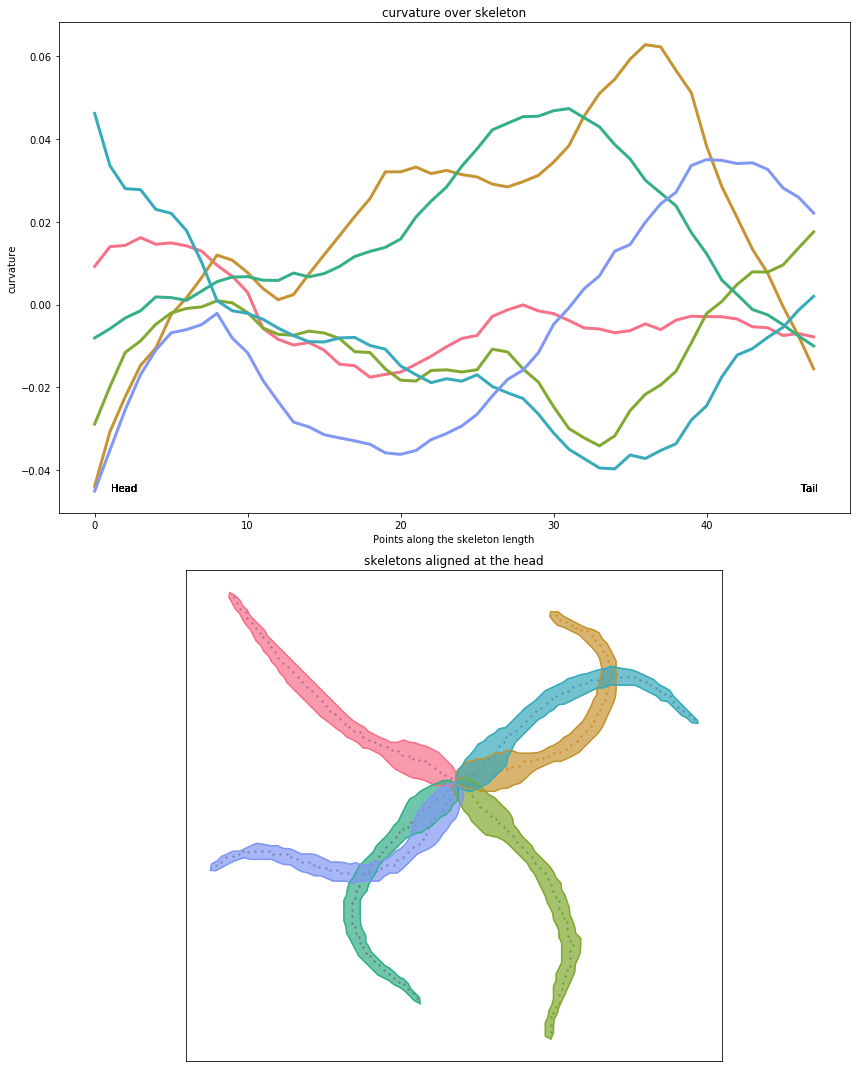

In [8]:
# extract the features

skeleton_array = masked_skeleton_array[:,:-1,:]

curv = get_curv_savgol(skeleton_array)

fig, axes = plt.subplots(2,1,figsize=(12,15))
n_skel = 7
sampling_indices = random.sample(range(0,curv.shape[0]-1), n_skel)
c_pal = sns.color_palette("husl", n_skel)
c_pal[6]=c_pal[5]
skel_len_array = np.array(skel_obj['skeleton_length'])
skel_len_array = skel_len_array[mask]

# sampling_indices = [5917,4495,7286,4474, 1038, 3874]
sampling_indices = [1972,  1776, 2925,   5079,  2898, 1731]
print(len(sampling_indices), curv.shape, len(c_pal))
for i, ind in enumerate(sampling_indices):
    
    if i == 0:
        head_ori = skeleton_array[ind,0,:]
        diff = 0
        
    else :             
        diff = head_ori - skeleton_array[ind,0,:]
        
    # align at the head
    skel_frame = skeleton_array[ind,:,:] + diff 
    c1_frame = contour1_array[ind,:,:] + diff 
    c2_frame = contour2_array[ind,:,:] + diff 
    
    print(ind,i, skel_len_array[ind])

    axes[0].plot(curv[ind,:], c= c_pal[i], linewidth=3)
    axes[0].set_title('curvature over skeleton')
    axes[0].set_ylabel('curvature')
    axes[0].set_xlabel('Points along the skeleton length')
    axes[0].annotate('Head',xy=(0.9,-0.045),xytext=(1.1,-0.045),              
            annotation_clip=False)
    axes[0].annotate('Tail',xy=(45.9,-0.045),xytext=(46.1,-0.045),              
            annotation_clip=False)

    axes[1].scatter(skel_frame[:,0],skel_frame[:,1], s=2)
    axes[1].plot(c1_frame[:,0],c1_frame[:,1], c= c_pal[i])
    axes[1].plot(c2_frame[:,0],c2_frame[:,1], c= c_pal[i])
    c12_x = np.concatenate((c1_frame[:,0],np.flipud(c2_frame[:,0])))
    c12_y = np.concatenate((c1_frame[:,1],np.flipud(c2_frame[:,1])))
    axes[1].fill(c12_x,c12_y, c= c_pal[i], alpha= 0.7, label=skel_len_array[ind])
    axes[1].set_title('skeletons aligned at the head')
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].set_aspect('equal')
    

#     axes[1].annotate('Head',xy=[skel_frame[0,0],skel_frame[0,1]])

plt.tight_layout(h_pad = 1.0)
plt.savefig('../figures1/curvature_examples4.svg')

# Defining features for the paper

Let us choose one nice skeleton on which we can illustrate the features. 

Maybe smoothen the skeleton and contours for a nice apperance ?

Plotting the skeleton and the contours

In [9]:
skeleton_array = np.array(skel_obj['skeleton'])
skeleton_array = skeleton_array[mask,:,:]
skeleton_array.shape


skeleton_array_savgol = savgol_skeleton(skeleton_array)
contour1_array_savgol = savgol_skeleton(contour1_array)
contour2_array_savgol = savgol_skeleton(contour2_array)


# skeleton_array_savgol = skeleton_array
# contour1_array_savgol = contour1_array
# contour2_array_savgol = contour2_array


contour1_array_savgol[:,0,:] = skeleton_array_savgol[:,0,:]
contour2_array_savgol[:,0,:] = skeleton_array_savgol[:,0,:]

contour1_array_savgol[:,-1,:] = skeleton_array[:,-1,:]
contour2_array_savgol[:,-1,:] = skeleton_array[:,-1,:]
skeleton_array_savgol[:,-1,:] = skeleton_array[:,-1,:]


In [10]:
slider_frame = widgets.IntSlider(value= 2951,
                                        min=0,
                                        max= skeleton_array.shape[0]-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

cpal = sns.color_palette("hls",9)

color_dict = {}



@widgets.interact
def plot_ciona_segments(ind = slider_frame):
    
    
    sample_skel = skeleton_array_savgol[ind,:,:] + diff 
    sample_cont1 = contour1_array_savgol[ind,:,:] + diff 
    sample_cont2 = contour2_array_savgol[ind,:,:] + diff
    
    fig, axes = plt.subplots(1,1,figsize=(5,5))

    axes.scatter(sample_skel[:,0],sample_skel[:,1], s=2)
    axes.plot(sample_cont1[:,0],sample_cont1[:,1], c= c_pal[i])
    axes.plot(sample_cont2[:,0],sample_cont2[:,1], c= c_pal[i])
    c12_x = np.concatenate((sample_cont1[:,0],np.flipud(sample_cont2[:,0])))
    c12_y = np.concatenate((sample_cont1[:,1],np.flipud(sample_cont2[:,1])))
    axes.fill(c12_x,c12_y, c= c_pal[i], alpha= 0.7, label=skel_len_array[ind])
    axes.axis('equal')
    

interactive(children=(IntSlider(value=2951, continuous_update=False, description='Frames:', max=7979), Output(…

Let us bring in all the code necessary to segment the ciona body

In [11]:
ind = 2951

In [12]:
def body_partitions_framewise(neck):
    
    segments_ind = {        
                'neck' : [(neck-1)/48, (neck+1)/48], 
                'head' : [0, (neck-1)/48],
#                 'head_tip' : [0, int(np.round((neck-1)/2))/48],
#                 'head_base' : [int(np.round((neck-1)/2))/48, (neck-1)/48],
                'tail': [(neck+1)/48 ,1],
                'tail_base': [(neck+1)/48 ,int(np.round((49-(neck+1))/5)+(neck+1))/48],
                'tail_pre_mid': [int(np.round((49-(neck+1))/5)+(neck+1))/48, int(np.round(2*(49-(neck+1))/5)+(neck+1))/48],
                'tail_mid': [ int(np.round(2*(49-(neck+1))/5)+(neck+1))/48,int(np.round(3*(49-(neck+1))/5)+(neck+1))/48],
                'tail_post_mid': [int(np.round(3*(49-(neck+1))/5)+(neck+1))/48, int(np.round(4*(49-(neck+1))/5)+(neck+1))/48],
                'tail_tip': [int(np.round(4*(49-(neck+1))/5)+(neck+1))/48,1]
            }
    
    return segments_ind

In [13]:
def get_segment_indices(contour_width,neck_point):
    
    max_skel_index = contour_width.shape[-1] - 1 # default : 48
    segments_ind_dflt = body_partitions_framewise(neck_point)
    segments_ind = { k: [int(round(x[0]*max_skel_index)),int(round(x[1]*max_skel_index))] for k,x in segments_ind_dflt.items()}
    return segments_ind

In [14]:
def segment_contours_fw(contour_1, contour_2, segments_ind):
    
    contour_dict = {}
    
    for key, ind_bound in segments_ind.items():
        
        contour_1_x = contour_1[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = contour_2[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = np.flipud(contour_2_x)
        
        contour_1_y = contour_1[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = contour_2[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = np.flipud(contour_2_y)
        
        contour_x = np.concatenate((contour_1_x, contour_2_x))
        contour_y = np.concatenate((contour_1_y, contour_2_y))
        contour_dict[key] = np.array([contour_x, contour_y])
        
    return contour_dict

In [15]:
def calc_centroids_fw(segments_ind, neck_point):
    centroid_dict = {}
    
    for key, value in segments_ind.items():
        
        centroid_dict[key] = round((value[0] + value[1])/2)
    
    centroid_dict['neck'] = neck_point
#     centroid_dict['tail'] = segments_ind['tail_mid_distal'][0]
#     centroid_dict['head'] = segments_ind['head_base'][0]
    
    centroid_dict['tail'] = centroid_dict['tail_mid']
    #centroid_dict['head'] = segments_ind['head_base'][0]
    return centroid_dict

In [16]:
neck_ind_array = np.array(skel_obj['neck_point_array'])
masked_neck_ind_array = neck_ind_array[mask]

In [17]:
contour_width_array = np.array(skel_obj['contour_width'])
masked_contour_width_array = contour_width_array[mask,:]

In [18]:
segments_ind = get_segment_indices(masked_contour_width_array[ind],masked_neck_ind_array[ind])
segments_ind

{'neck': [11, 13],
 'head': [0, 11],
 'tail': [13, 48],
 'tail_base': [13, 20],
 'tail_pre_mid': [20, 27],
 'tail_mid': [27, 35],
 'tail_post_mid': [35, 42],
 'tail_tip': [42, 48]}

In [19]:
sample_skel = skeleton_array_savgol[ind,:,:] + diff 
sample_cont1 = contour1_array_savgol[ind,:,:] + diff 
sample_cont2 = contour2_array_savgol[ind,:,:] + diff

In [20]:
contour_dict = segment_contours_fw(sample_cont1, sample_cont2, segments_ind)

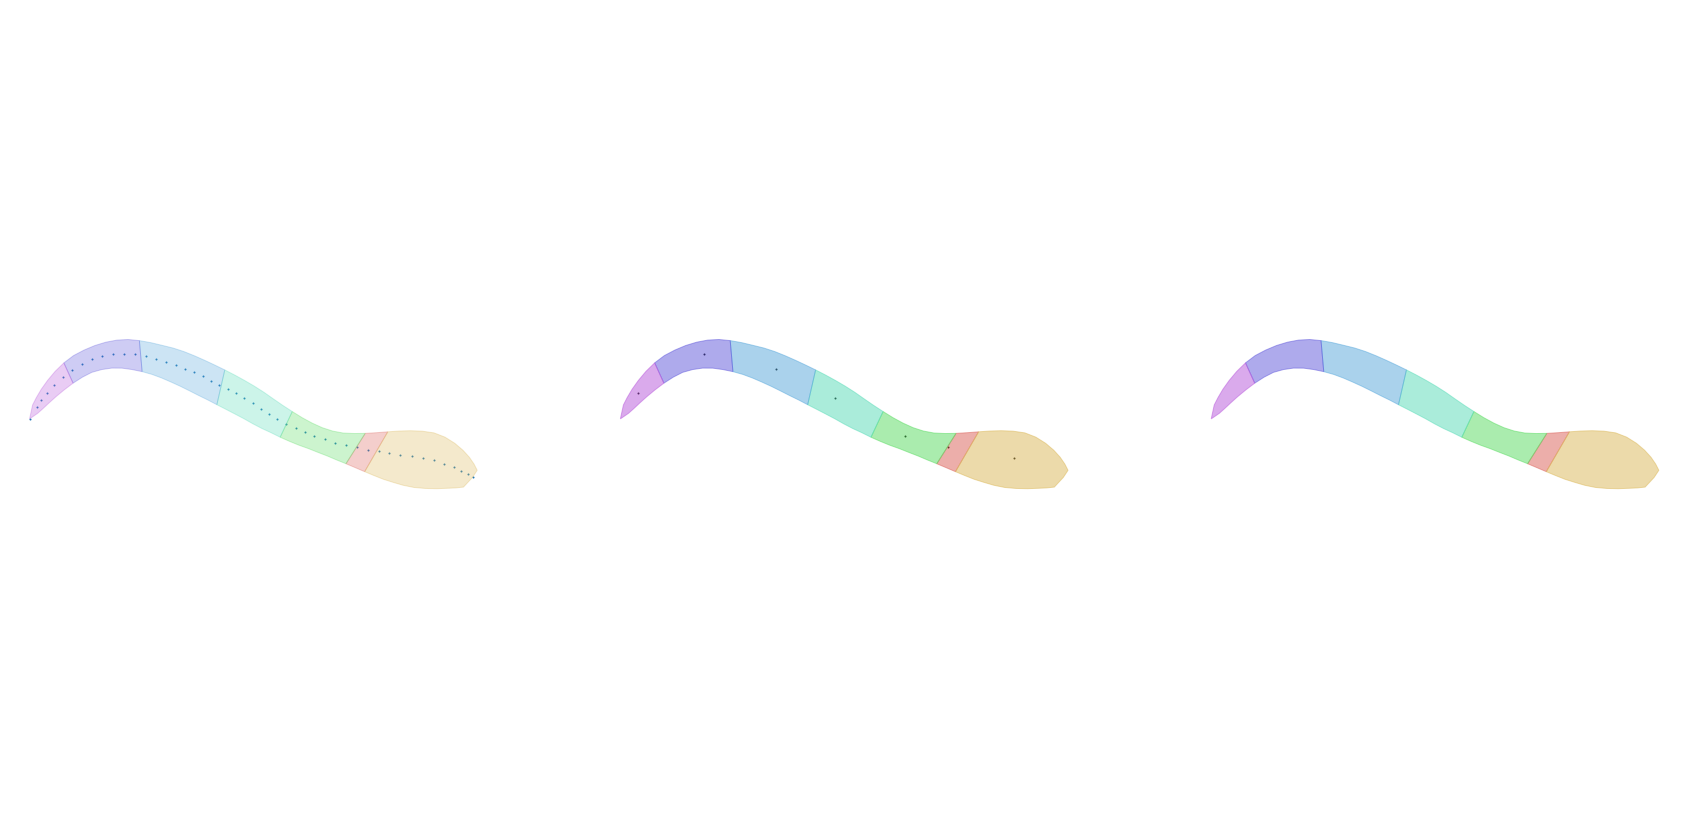

In [21]:
fig, axes = plt.subplots(1,3,figsize=(30,15))
cpal = sns.color_palette("hls",9)
color_dict = {}
for key, color in zip(contour_dict.keys(), cpal):
    color_dict[key] = color
    
centroid_dict = calc_centroids_fw(segments_ind, masked_neck_ind_array[ind])

# Plot skeleton points
axes[0].scatter(sample_skel[:,0],sample_skel[:,1], s=1)

for key, val in contour_dict.items():
    if key not in ['tail']:
        axes[0].fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.3)
        axes[1].fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.5)
        axes[2].fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.5)
    
        axes[1].scatter(sample_skel[centroid_dict[key],0],sample_skel[centroid_dict[key],1],c='k',s=1)
        
        
#     if key in ['head','tail_base','tail_pre_mid','tail_post_mid', 'tail_tip']:
#         seg_start = segments_ind[key][0]
#         seg_end = segments_ind[key][1]
        
#         seg_x = [sample_skel[seg_start,0],sample_skel[seg_end,0]]
#         seg_y = [sample_skel[seg_start,1],sample_skel[seg_end,1]]
#         axes[0].plot(seg_x, seg_y,c=color_dict[key], lw=3)
    
    
for ax in axes:
    ax.axis('equal')
    ax.axis('off')

plt.savefig('../figures1/feature_definitions.svg')

(604.1910980224609, 709.9869415283204, 497.39450988769534, 532.6535247802734)

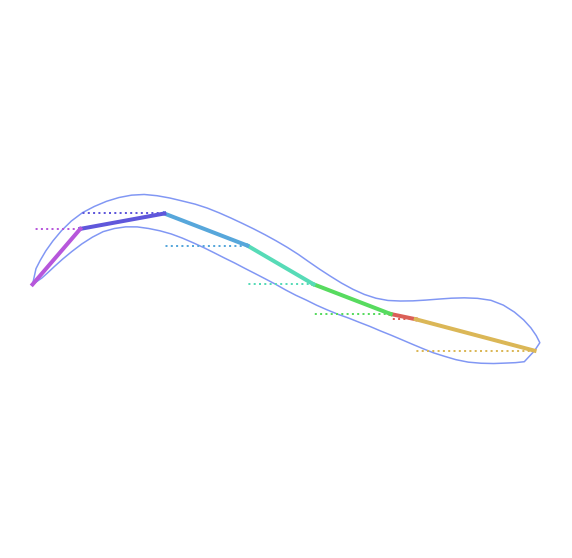

In [22]:
fig, axes = plt.subplots(1,1,figsize=(10,10))

# axes.scatter(sample_skel[:,0],sample_skel[:,1], s=2)
axes.plot(sample_cont1[:,0],sample_cont1[:,1], c= c_pal[i])
axes.plot(sample_cont2[:,0],sample_cont2[:,1], c= c_pal[i])
# c12_x = np.concatenate((sample_cont1[:,0],np.flipud(sample_cont2[:,0])))
# c12_y = np.concatenate((sample_cont1[:,1],np.flipud(sample_cont2[:,1])))
# axes.fill(c12_x,c12_y, c= 'k', label=skel_len_array[ind])

for key, val in contour_dict.items():
    if key not in ['tail']:
        seg_start = segments_ind[key][0]
        seg_end = segments_ind[key][1]

        seg_x = [sample_skel[seg_start,0],sample_skel[seg_end,0]]
        seg_y = [sample_skel[seg_start,1],sample_skel[seg_end,1]]
        base_y = [sample_skel[seg_start,1],sample_skel[seg_start,1]]
        axes.plot(seg_x, seg_y,c=color_dict[key], lw=4)
        axes.plot(seg_x, base_y,c=color_dict[key], lw=2, ls=':')
        
        
axes.axis('equal')
axes.axis('off')



In [23]:
curv_array = get_curv_savgol(skeleton_array_savgol)

## Tangents and osculating circle

Let us try plotting the tangent and perpendicular to tangent lines for a curve.

Ref : https://stackoverflow.com/a/52461003/5226311

/share/python-virtual-environments/ciona_behaviour/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


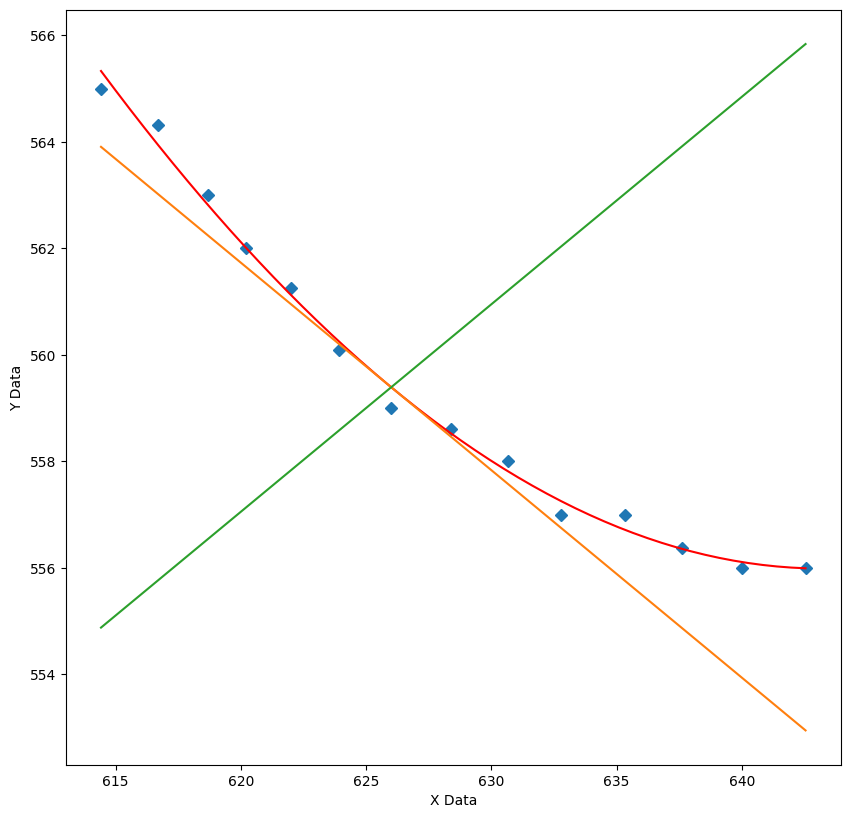

In [27]:

xData = skeleton_array[ind,9:23,0]
yData = skeleton_array[ind,9:23,1]

# polynomial curve fit the test data
fittedParameters = np.polyfit(xData, yData, 4)


##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(10,10), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = np.polyval(fittedParameters, xModel)

    # now the model as a line plot
    axes.plot(xModel, yModel,'r')

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    # polynomial derivative from np
    deriv = np.polyder(fittedParameters)
    
    
    # for plotting
    minX = min(xData)
    maxX = max(xData)

    # value of derivative (slope) at a specific X value, so
    # that a straight line tangent can be plotted at the point
    # you might place this code in a loop to animate
    pointVal = skeleton_array[ind,16,0] # example X value
    y_value_at_point = np.polyval(fittedParameters, pointVal)
    slope_at_point = np.polyval(deriv, pointVal)
    
    slope_of_radius = -1 * slope_at_point

    ylow = (minX - pointVal) * slope_at_point + y_value_at_point
    yhigh = (maxX - pointVal) * slope_at_point + y_value_at_point
    # now the tangent as a line plot
    axes.plot([minX, maxX], [ylow, yhigh])
    
    
    ylow_r = (minX - pointVal) * slope_of_radius + y_value_at_point
    yhigh_r = (maxX - pointVal) * slope_of_radius + y_value_at_point
    # now the radii as a line plot
    axes.plot([minX, maxX], [ylow_r, yhigh_r])

    plt.show()
    plt.close('all') # clean up after using pyplot


graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)


In [1]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
cpal = sns.color_palette("hls",9)
color_dict = {}
for key, color in zip(contour_dict.keys(), cpal):
    color_dict[key] = color
    
centroid_dict = calc_centroids_fw(segments_ind, masked_neck_ind_array[ind])

# Plot skeleton points
axes.scatter(sample_skel[:,0],sample_skel[:,1], s=10)

for key, val in contour_dict.items():
    if key not in ['tail']:
        axes.fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.3)
        
    print(centroid_dict[key])
        
axes.axis('equal')
axes.axis('off')



NameError: name 'plt' is not defined

In [7]:
round(15.49)

15